In [1]:
import scanpy as sc
import json
import pandas as pd
import matplotlib.pyplot as plt
import scPAFA
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [2]:
adata_full = sc.read_h5ad('../scanpy_h5ad/20240722_GSE167522_MN_MT_PN_PT.h5ad')

In [3]:
adata_full.shape

(163347, 24662)

In [4]:
adata_full.obs['celltype_sub'].value_counts()

celltype_sub
hC14_CD8_MAIT-SLC4A10       12809
hC10_CD8_Trm-KLRB1           9571
hC22_CD4_Trm-CXCR6           9565
hC77_plasmaB-IGHA1|IGLC2     8177
hC06_CD8_Tem-CXCR5           7175
                            ...  
hC33_cDC-LAMP3                172
hC60_NK-SELL                  149
hC31_NKT-CD27                 130
hC55_Mph-MKI67                 95
hC01_CD8_Tn-LEF1               79
Name: count, Length: 80, dtype: int64

In [5]:
len(adata_full.obs['sample'].value_counts())

8

In [6]:
len(adata_full.obs['patient'].value_counts())

10

In [7]:
adata_full.obs['celltype_sub'] = adata_full.obs['celltype_sub'].str.replace('γδ','gd')
adata_full.obs['celltype_sub'] = adata_full.obs['celltype_sub'].astype('category')

In [8]:
adata_full.obs['celltype_sub'].value_counts()

celltype_sub
hC14_CD8_MAIT-SLC4A10       12809
hC10_CD8_Trm-KLRB1           9571
hC22_CD4_Trm-CXCR6           9565
hC77_plasmaB-IGHA1|IGLC2     8177
hC06_CD8_Tem-CXCR5           7175
                            ...  
hC33_cDC-LAMP3                172
hC60_NK-SELL                  149
hC31_NKT-CD27                 130
hC55_Mph-MKI67                 95
hC01_CD8_Tn-LEF1               79
Name: count, Length: 80, dtype: int64

In [3]:
with open('/data/scPAFA_paper/pathway/20231025_geneset_bioplanet_hallmark_3CA_1857.json', 'r') as file:
    pathway_dict = json.load(file)

rank_matrix = scPAFA.tl.fast_ucell_rank(adata=adata_full,maxRank=2000,n_cores_rank=10,rank_batch_size=90000)
pathway_input = scPAFA.tl.generate_pathway_input(adata = adata_full,pathway_dict= pathway_dict,min_overlap_gene=6)
Ucell_result =  scPAFA.tl.fast_ucell_score(cell_index = list(adata_full.obs.index),rankmatrix=rank_matrix,maxRank=2000,n_cores_score=10,score_batch_size = 90000,input_dict = pathway_input)

adata.X is csr sparse matrix
Step1 generate rank matrix
2 batches need to rank, with each max 90000 cells
Processing_batch_1


Ranking Chunks: 100%|██████████| 10/10 [02:18<00:00, 13.87s/it]


Processing_batch_2


Ranking Chunks: 100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


Rank done
The output rank matrix can be used to calculate UCell score on different pathways set.
The maxRank parameter use with this rank matrix in fast_ucell_score() must <= 2000
Filtered out 221 pathways
1636 pathways passed QC
The maxRank must >= 1615 (The genes number of the longest pathway)
Subset rank matrix by overlap genes in pathways
Rank above maxRank to 0
step2 calculating Score
2 batches need to score, with each max 90000 cells
processing_batch_1


Pathways: 100%|██████████| 1636/1636 [01:38<00:00, 16.57it/s]


processing_batch_2


Pathways: 100%|██████████| 1636/1636 [01:21<00:00, 20.08it/s]


Ucell_done
Outputing_dataframe


In [7]:
Ucell_result.to_parquet('../plot/20240722_GSE167522_MN_MT_PN_PT.parquet')

In [16]:
random = 2024
pseudobulk_table = scPAFA.pb.generate_scpafa_input(metadata=adata_full.obs,
                                                    PAS_dataframe=Ucell_result,
                                                    min_cell_number_per_sample=5,
                                                    min_sample_per_view = 20,
                                                    sample_column='patient_tissue',
                                                    view_column='celltype_sub',
                                                    top_percentage=0.25)

MOFA_model = scPAFA.pb.run_mofapy2(long_table=pseudobulk_table,
                                       scale_views=True,
                                       factor_number=10,
                                       random_seed=random,
                                       dropR2=0.01,
                                       convergence_mode='fast')
MOFA_model.save(f'../plot/20240721_mofa_singlegroup_{random}.hdf5')

import mofax as mfx
MOFA_model = mfx.mofa_model(f'../plot/20240721_mofa_singlegroup_{random}.hdf5')

Select the top 409 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\scPAFA        ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...


No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='CD3D-CD4+' with N=39 samples and D=409 features...
Loaded group='single_group' view='CD45-' with N=35 samples and D=409 features



######################################
## Training the model with seed 2024 ##
######################################


ELBO before training: -5835410.54 

Iteration 1: time=0.48, ELBO=-1238415.94, deltaELBO=4596994.606 (78.77756967%), Factors=9
Iteration 2: time=0.43, ELBO=-1122281.21, deltaELBO=116134.723 (1.99017228%), Factors=8
Iteration 3: time=0.37, ELBO=-1088714.79, deltaELBO=33566.424 (0.57521957%), Factors=8
Iteration 4: time=0.37, ELBO=-1069768.11, deltaELBO=18946.684 (0.32468468%), Factors=8
Iteration 5: time=0.37, ELBO=-1057646.54, deltaELBO=12121.566 (0.20772431%), Factors=8
Iteration 6: time=0.37, ELBO=-1049916.18, deltaELBO=7730.360 (0.13247328%), Factors=8
Iteration 7: time=0.37, ELBO=-1045009.01, deltaELBO=4907.170 (0.08409296%), Factors=8
Iteration 8: time=0.36, ELBO=-1041838.26, deltaELBO=3170.748 (0.05433633%), Factors=8
Iteration 9: time=0.37, ELBO=-1039717.06, deltaELBO=2121.198 (0.03635045%), Factors=8
Iteration 10: time=0.37, ELBO=-1038235.62, deltaELBO=1481.4

Iteration 96: time=0.36, ELBO=-963242.21, deltaELBO=35.064 (0.00060089%), Factors=8
Iteration 97: time=0.37, ELBO=-963208.37, deltaELBO=33.839 (0.00057989%), Factors=8
Iteration 98: time=0.36, ELBO=-963175.77, deltaELBO=32.593 (0.00055854%), Factors=8
Iteration 99: time=0.37, ELBO=-963144.43, deltaELBO=31.342 (0.00053709%), Factors=8
Iteration 100: time=0.36, ELBO=-963114.33, deltaELBO=30.100 (0.00051582%), Factors=8
Iteration 101: time=0.37, ELBO=-963085.45, deltaELBO=28.881 (0.00049493%), Factors=8
Iteration 102: time=0.36, ELBO=-963057.76, deltaELBO=27.695 (0.00047460%), Factors=8

Converged!



#######################
## Training finished ##
#######################


Saving model in ../plot/20240721_mofa_singlegroup_2024.hdf5...


In [9]:
import mofax as mfx
MOFA_model = mfx.mofa_model(f'../plot/20240721_mofa_singlegroup_2024.hdf5')

In [10]:
factor_matrix = pd.concat(MOFA_model.get_factors(df=True,concatenate_groups =False,scale=True))

sample_meta = adata_full.obs[['tissue','patient_tissue','patient','ID']]
sample_meta = sample_meta.drop_duplicates(subset='patient_tissue')
sample_meta.index = sample_meta['patient_tissue']
sample_meta = sample_meta.loc[factor_matrix.index,:]

group_test_result = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='tissue')

In [11]:
sample_meta.shape

(40, 4)

In [12]:
sample_meta[['MorP', 'TorN']] = sample_meta['tissue'].str.split(' ', expand=True)

In [13]:
sample_meta.to_csv('../plot/20240808_sample_meta.csv')

In [14]:
factor_matrix.to_csv('../plot/20240808_factor_meta.csv')

In [18]:
group_test_result2 = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='MorP')

In [19]:
group_test_result2

,Factor,p_value,p_adj,method
0,Factor1,0.379332,0.731121,Mann-Whitney U test
1,Factor2,0.860431,0.860431,Mann-Whitney U test
2,Factor3,0.839232,0.860431,Mann-Whitney U test
3,Factor4,0.000026,0.000117,Mann-Whitney U test
4,Factor5,0.060111,0.160295,Mann-Whitney U test
5,Factor6,0.000029,0.000117,Mann-Whitney U test
6,Factor7,0.675014,0.860431,Mann-Whitney U test
7,Factor8,0.456951,0.731121,Mann-Whitney U test


In [20]:
group_test_result3 = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='TorN')

In [21]:
group_test_result3

,Factor,p_value,p_adj,method
0,Factor1,4.734806e-01,0.839979,Mann-Whitney U test
1,Factor2,2.084536e-01,0.833814,Mann-Whitney U test
2,Factor3,9.031165e-01,0.903116,Mann-Whitney U test
3,Factor4,5.249869e-01,0.839979,Mann-Whitney U test
4,Factor5,4.538972e-07,0.000004,Mann-Whitney U test
5,Factor6,8.817308e-01,0.903116,Mann-Whitney U test
6,Factor7,6.553614e-01,0.873815,Mann-Whitney U test
7,Factor8,3.507022e-01,0.839979,Mann-Whitney U test


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


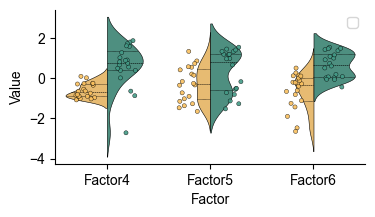

In [24]:
import seaborn as sns
factor_matrix_long = factor_matrix[['Factor4','Factor5','Factor6']].copy()
factor_matrix_long.loc[:,'MorP'] =  sample_meta.loc[factor_matrix_long.index,:]['MorP']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','MorP'], var_name='Factor', value_name='Value')
plt.figure(figsize=(4, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue='MorP', split=True, inner="quart",palette=["#FAC05E","#439A86"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="MorP", 
              dodge=True, jitter=0.2, alpha=0.9, size=3 ,palette=["#FAC05E","#439A86"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
sns.despine()
plt.savefig('../plot/20241104_MorP_violin.pdf',bbox_inches = "tight", transparent=True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


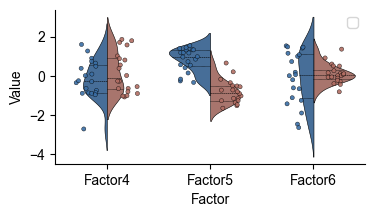

In [26]:
import seaborn as sns
factor_matrix_long = factor_matrix[['Factor4','Factor5','Factor6']].copy()
factor_matrix_long.loc[:,'TorN'] =  sample_meta.loc[factor_matrix_long.index,:]['TorN']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','TorN'], var_name='Factor', value_name='Value')
plt.figure(figsize=(4, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue='TorN', split=True, inner="quart",palette=["#3A6EA5","#B26E63"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="TorN", 
              dodge=True, jitter=0.2, alpha=0.9, size=3 ,palette=["#3A6EA5","#B26E63"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
plt.legend(loc='best') 
sns.despine()
plt.savefig('../plot/20241104_TorN_violin.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [19]:
a1 = scPAFA.pl.runumap_and_plot(sample_factor_df=factor_matrix[list(group_test_result[group_test_result['p_adj']<0.05]['Factor'])],metadata=sample_meta,label_column='tissue'
                              ,width=6,height=5,random_state=2024,point_size=3,color_mapping={"metastasis normal":"#3A6EA5","metastasis tumor":"#FAC05E","primary normal":"#439A86","primary tumor":"#B26E63"})

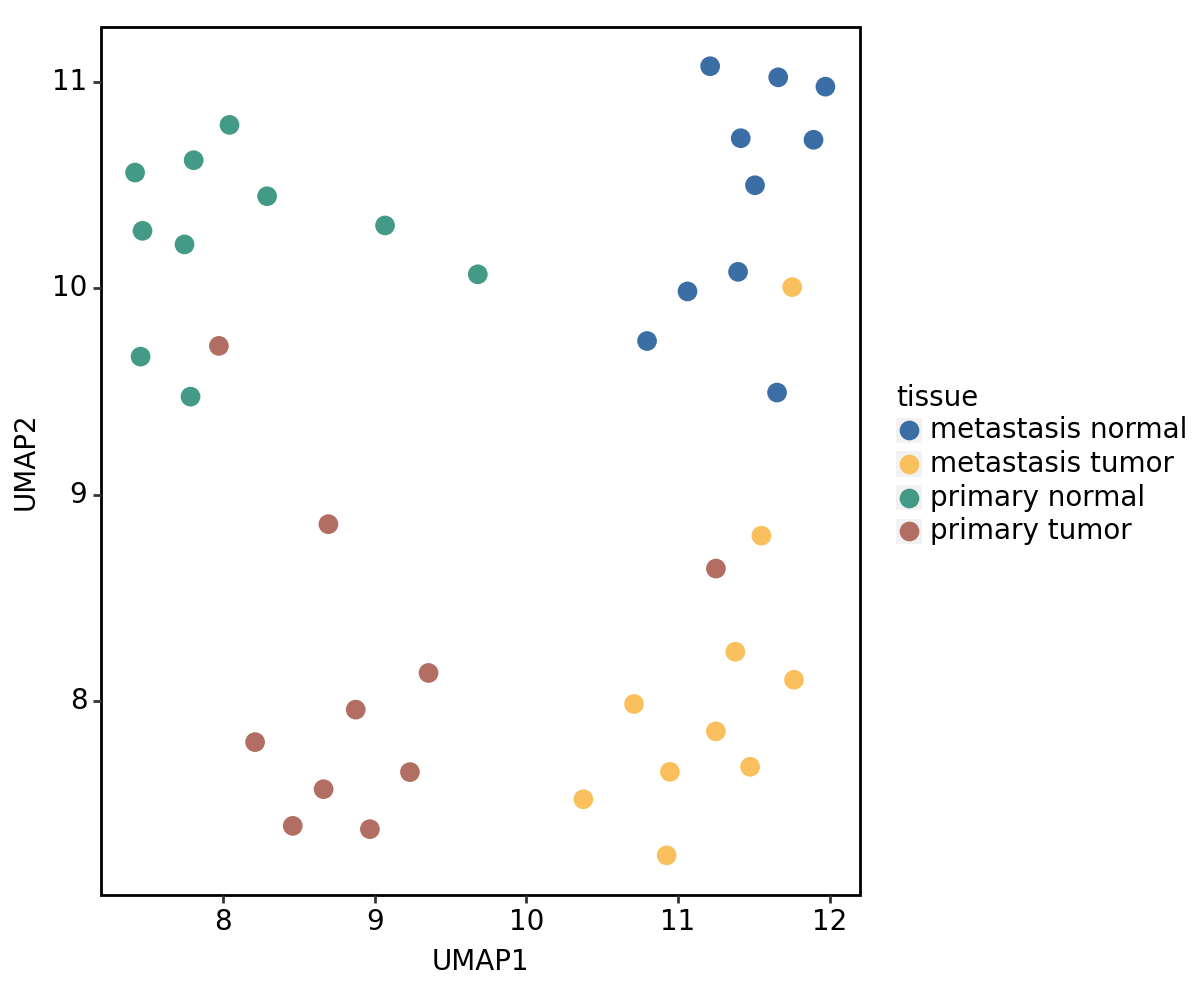

<Figure Size: (600 x 500)>

In [24]:
a1

In [21]:
a1.save('../plot/20240721_GSE164522_umap.pdf',bbox_inches = "tight")

In [23]:
cmaps = {"tissue":{"metastasis normal":"#3A6EA5","metastasis tumor":"#FAC05E","primary normal":"#439A86","primary tumor":"#B26E63"}}
scPAFA.pl.draw_cluster_heatmap(sample_factor_df=factor_matrix[list(group_test_result[group_test_result['p_adj']<0.05]['Factor'])],
                              sample_annotaion_df=pd.DataFrame(sample_meta['tissue']),
                              p_value_dataframe=group_test_result,
                              custom_cmap=cmaps,
                              figsize = (8,8))
plt.savefig('../plot/20240721_GSE164522_cluster_heatmap_factor4_5_6.pdf',bbox_inches = "tight")

In [25]:
MOFA_model.get_r2().to_csv('../plot/20240722_factor_r2.csv')

In [39]:
df_r2 = MOFA_model.get_r2()

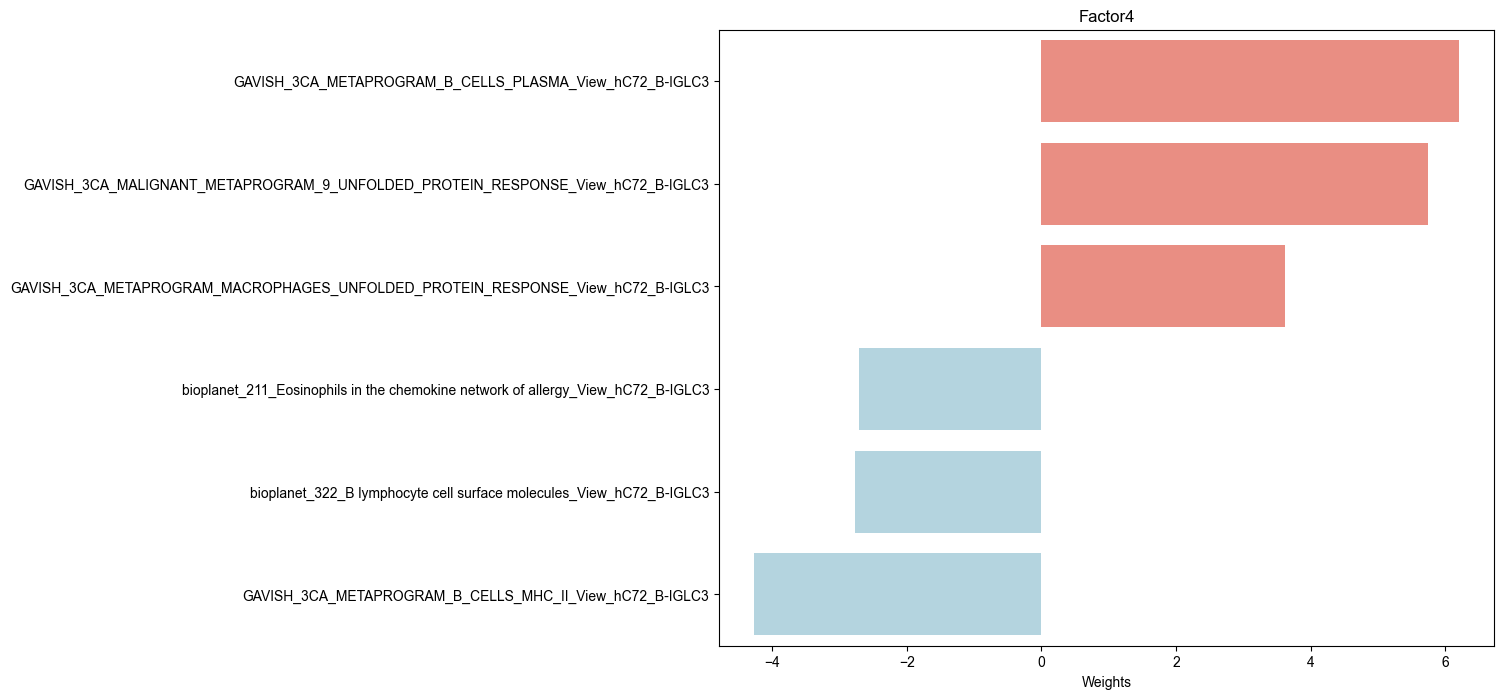

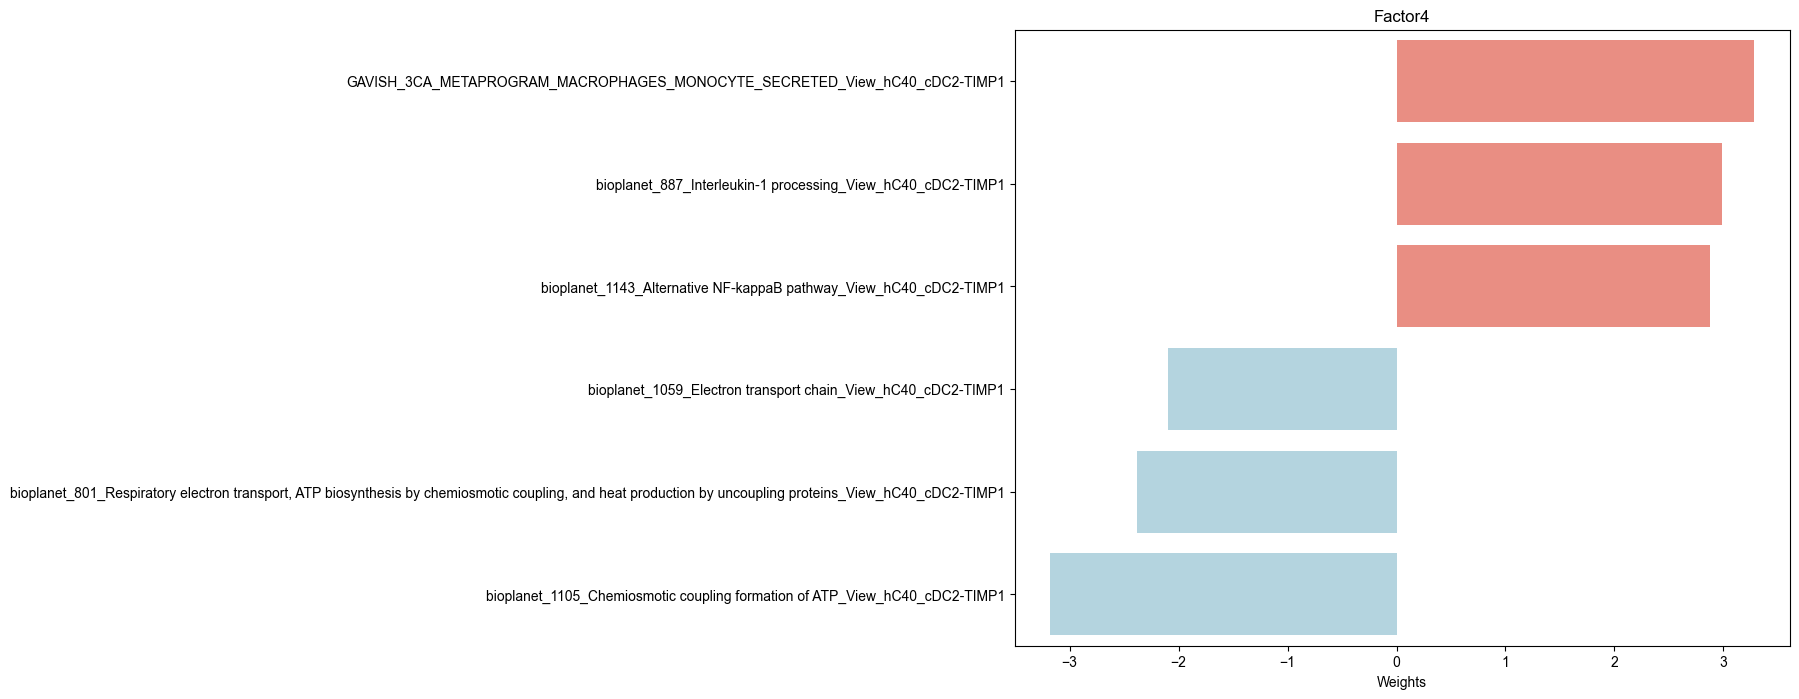

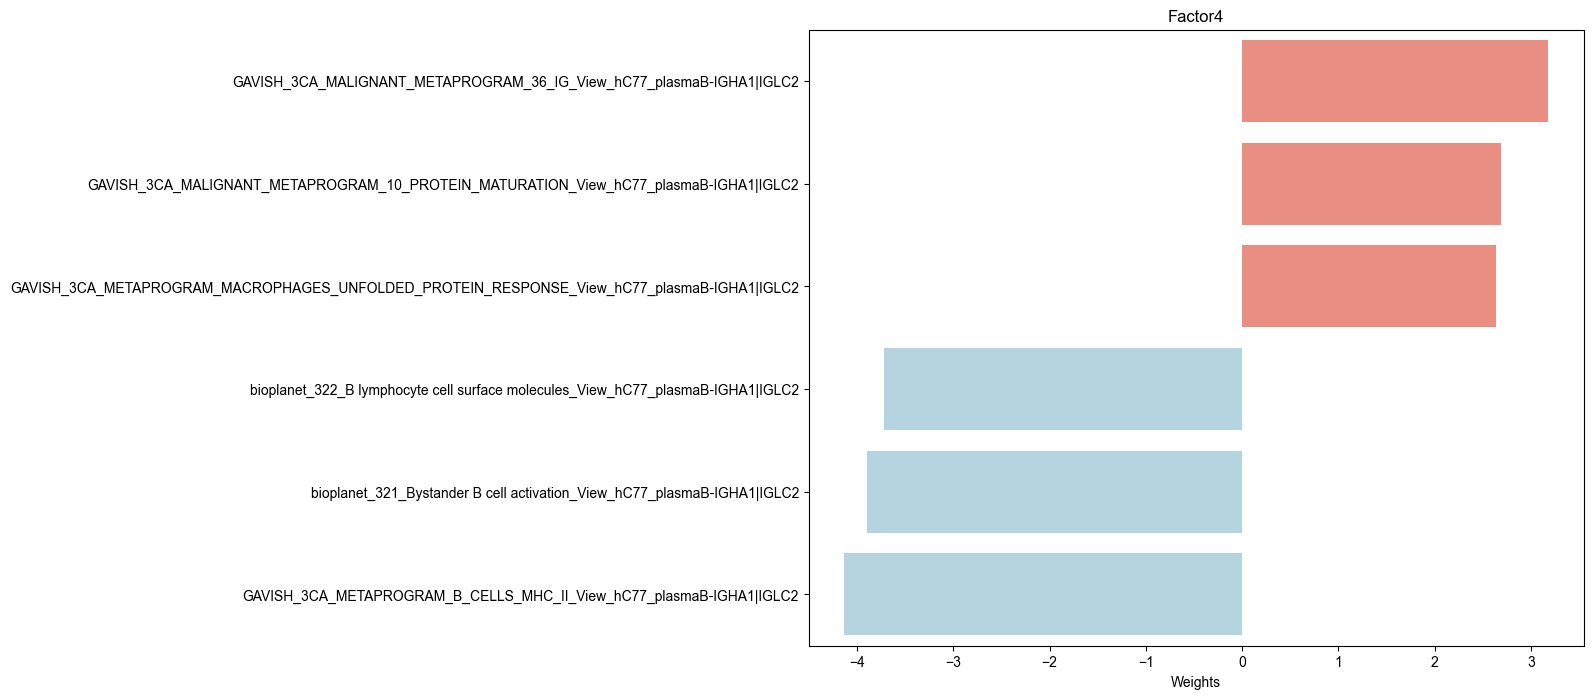

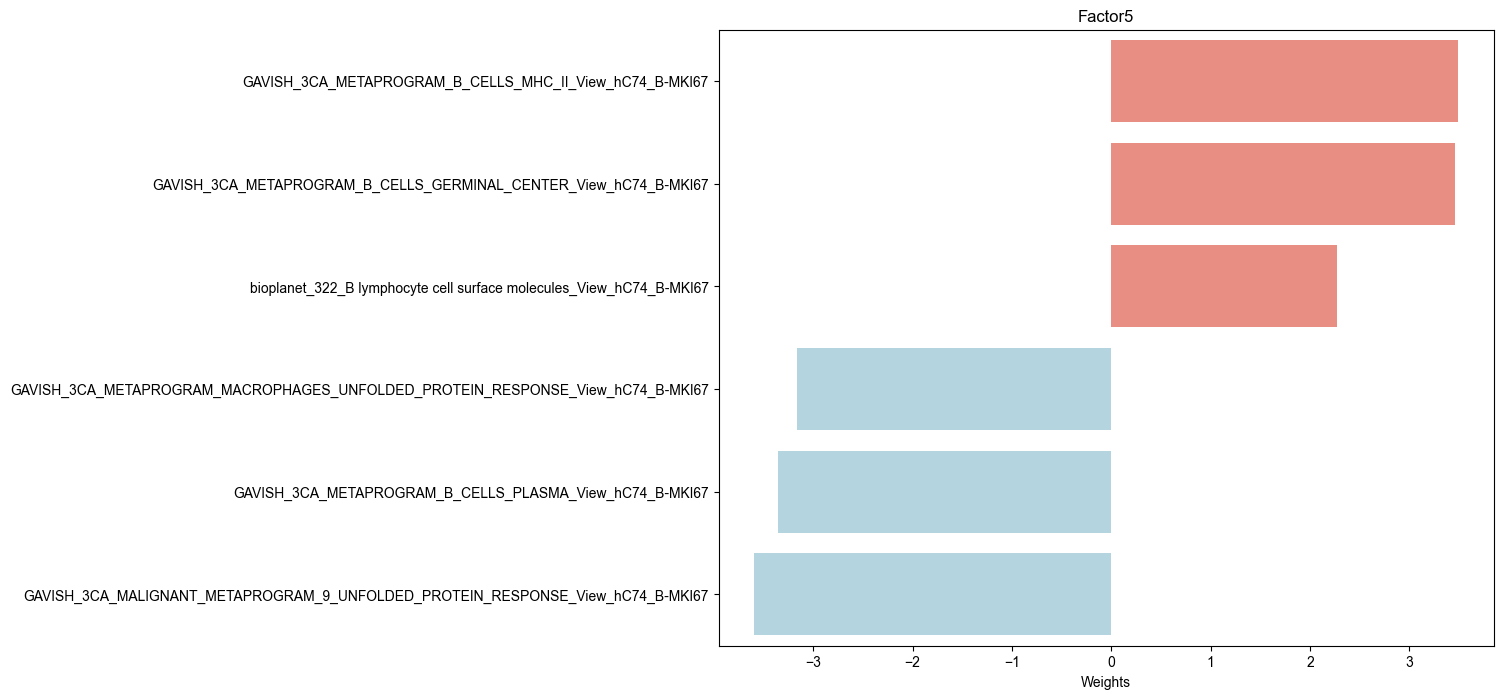

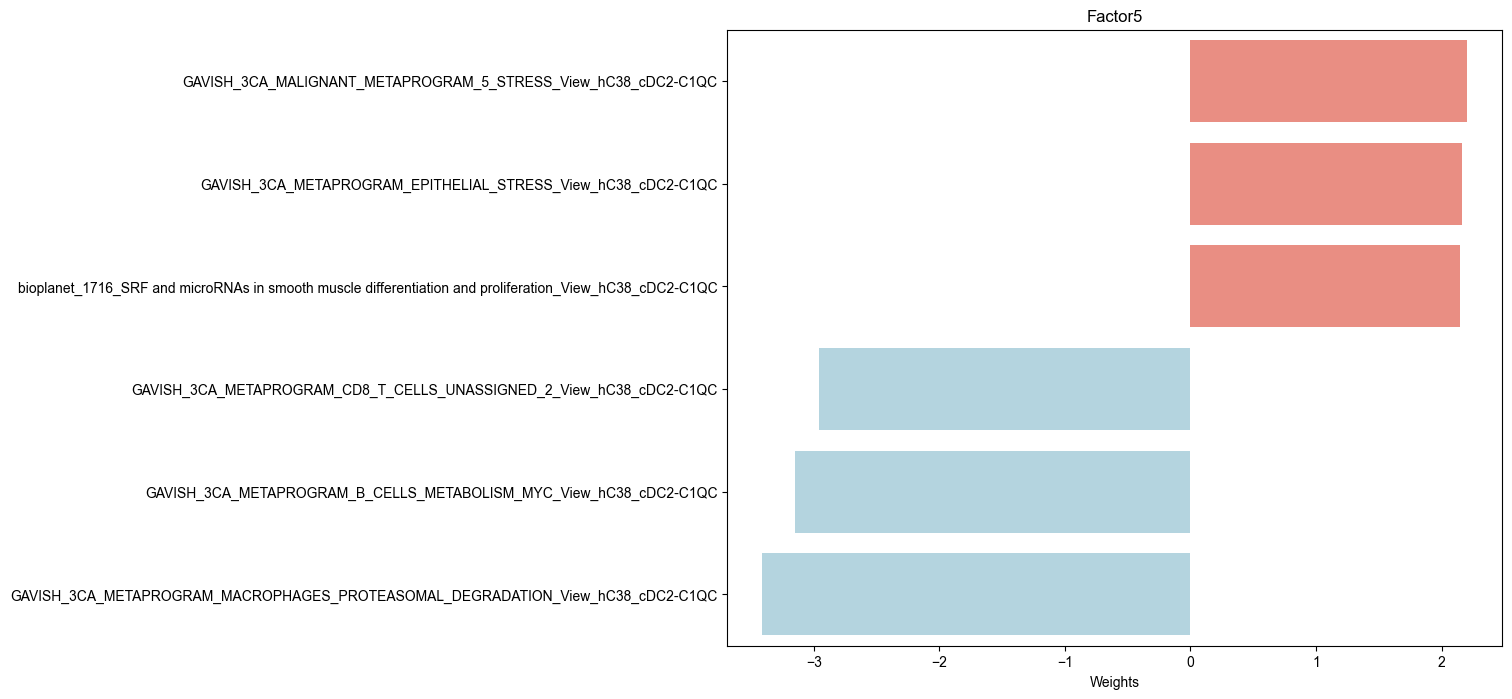

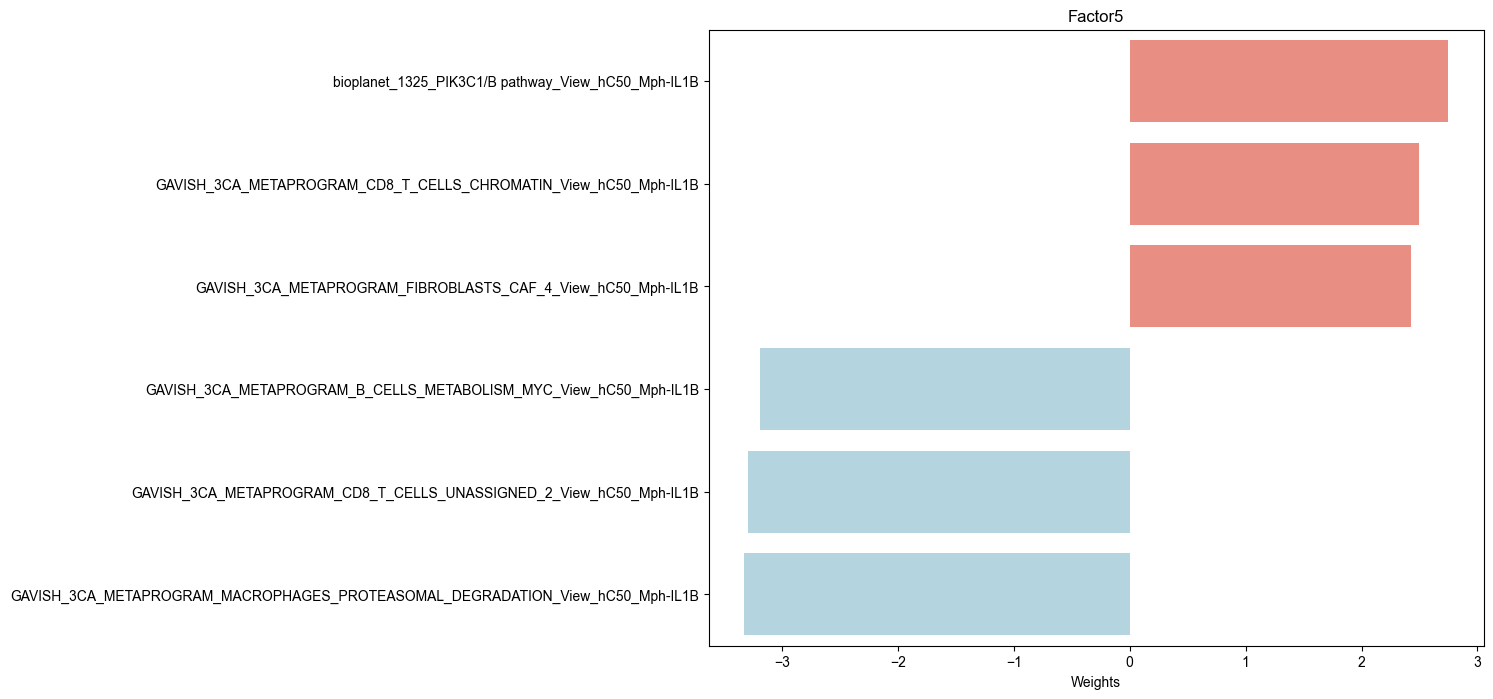

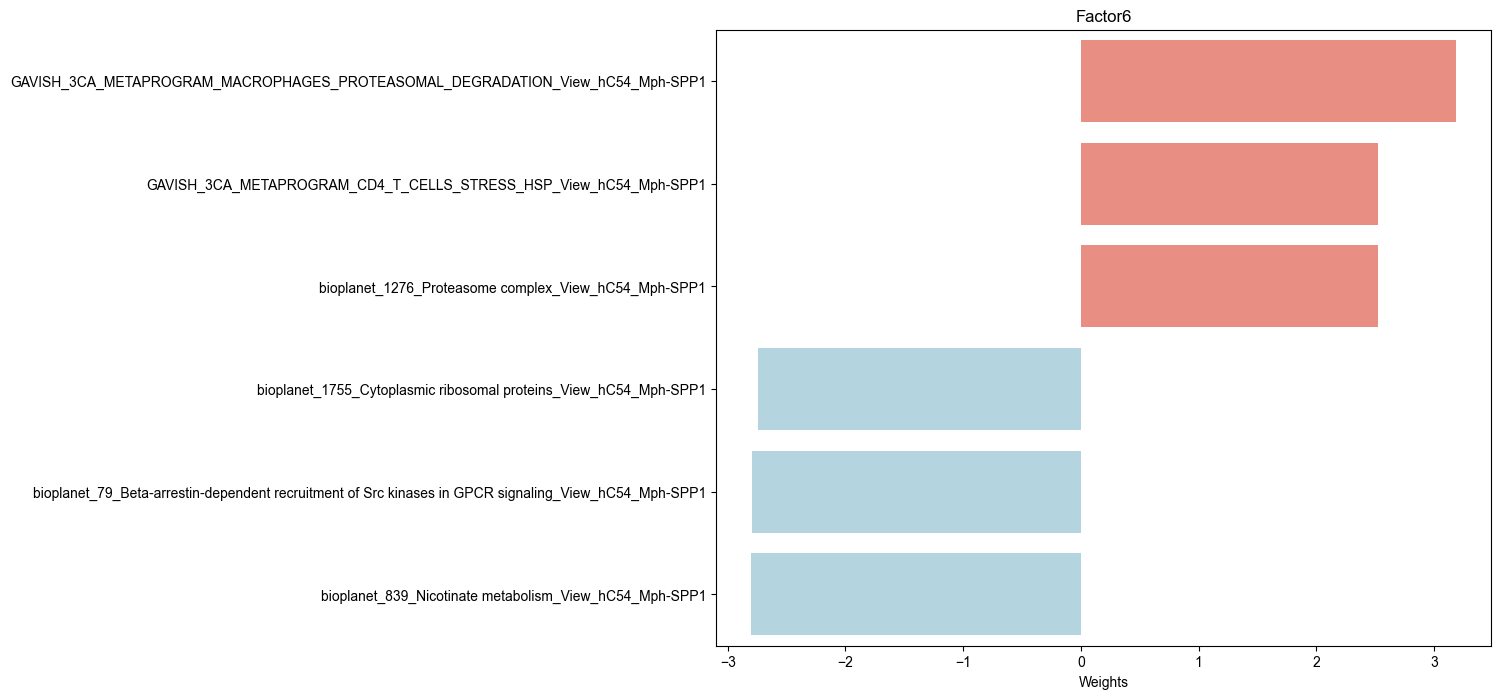

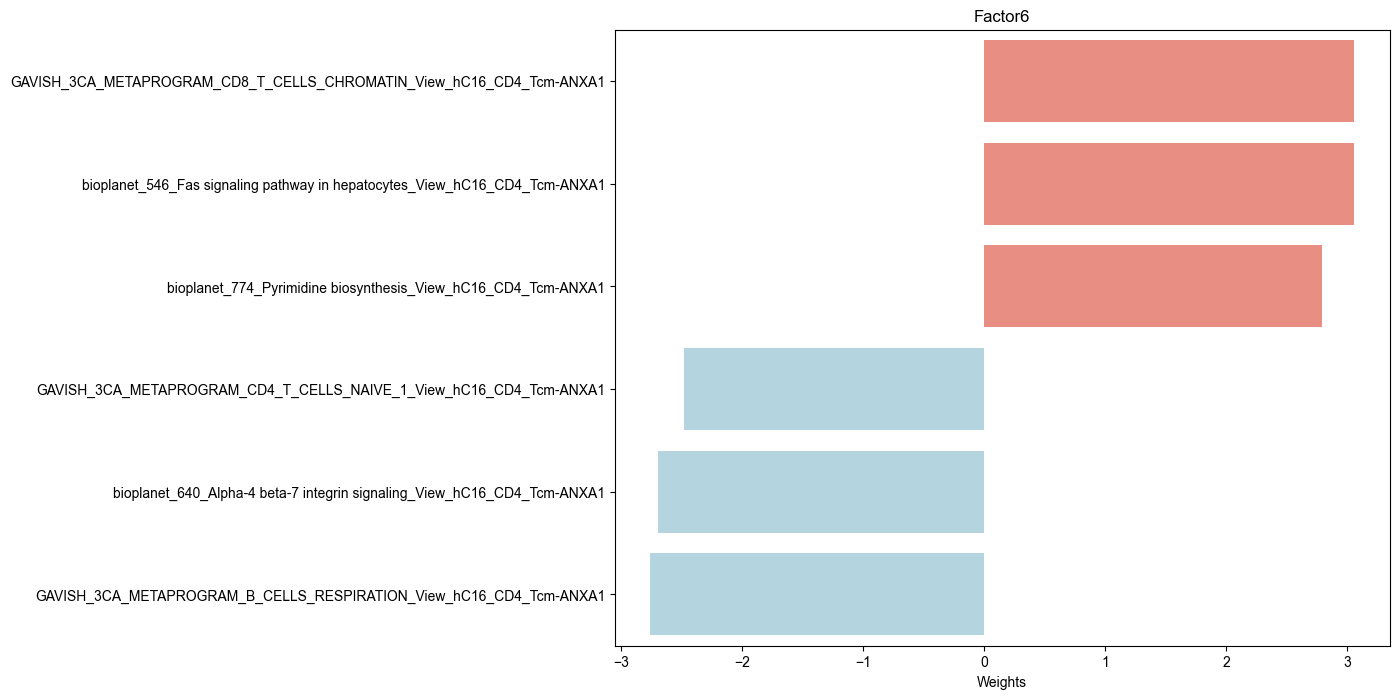

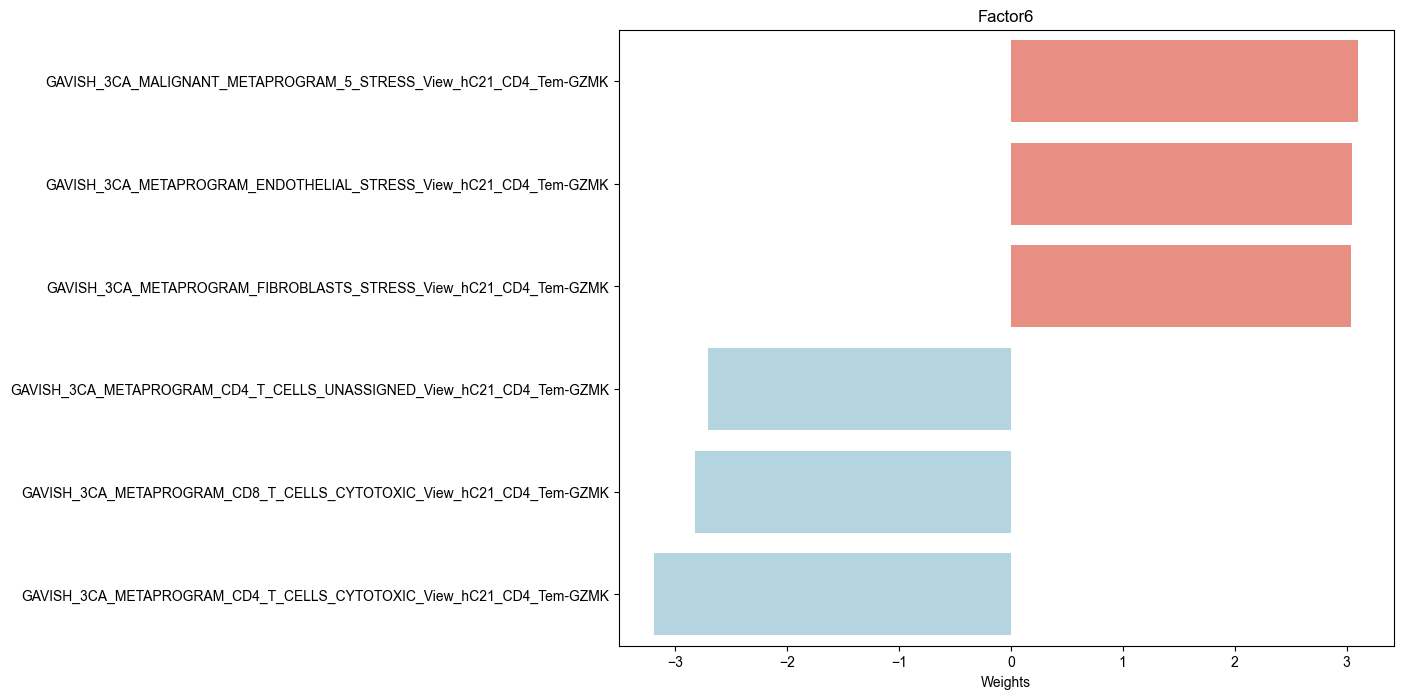

In [42]:
for sig_factor in ['Factor4','Factor5','Factor6']:
    
    df_r2_sig = df_r2[df_r2['Factor'] == sig_factor]
    df_r2_sig = df_r2_sig.loc[df_r2_sig['R2'].nlargest(3).index,]
    top3view = df_r2_sig['View'].values
    
    for sig_view in top3view:
        weight_matrix = MOFA_model.get_weights(scale=True,df =True,views=[sig_view])
        a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name=sig_factor,label_beside_bar=False,n_largest=3,n_smallest=3)
        a1.savefig(f'../plot/20240722_GSE164522_TOP3WEIGHT_{sig_factor}_{sig_view}.pdf',bbox_inches = "tight")

In [95]:
weight_matrix = pd.concat(MOFA_model.get_weights(scale=True,df =True,concatenate_views=False))

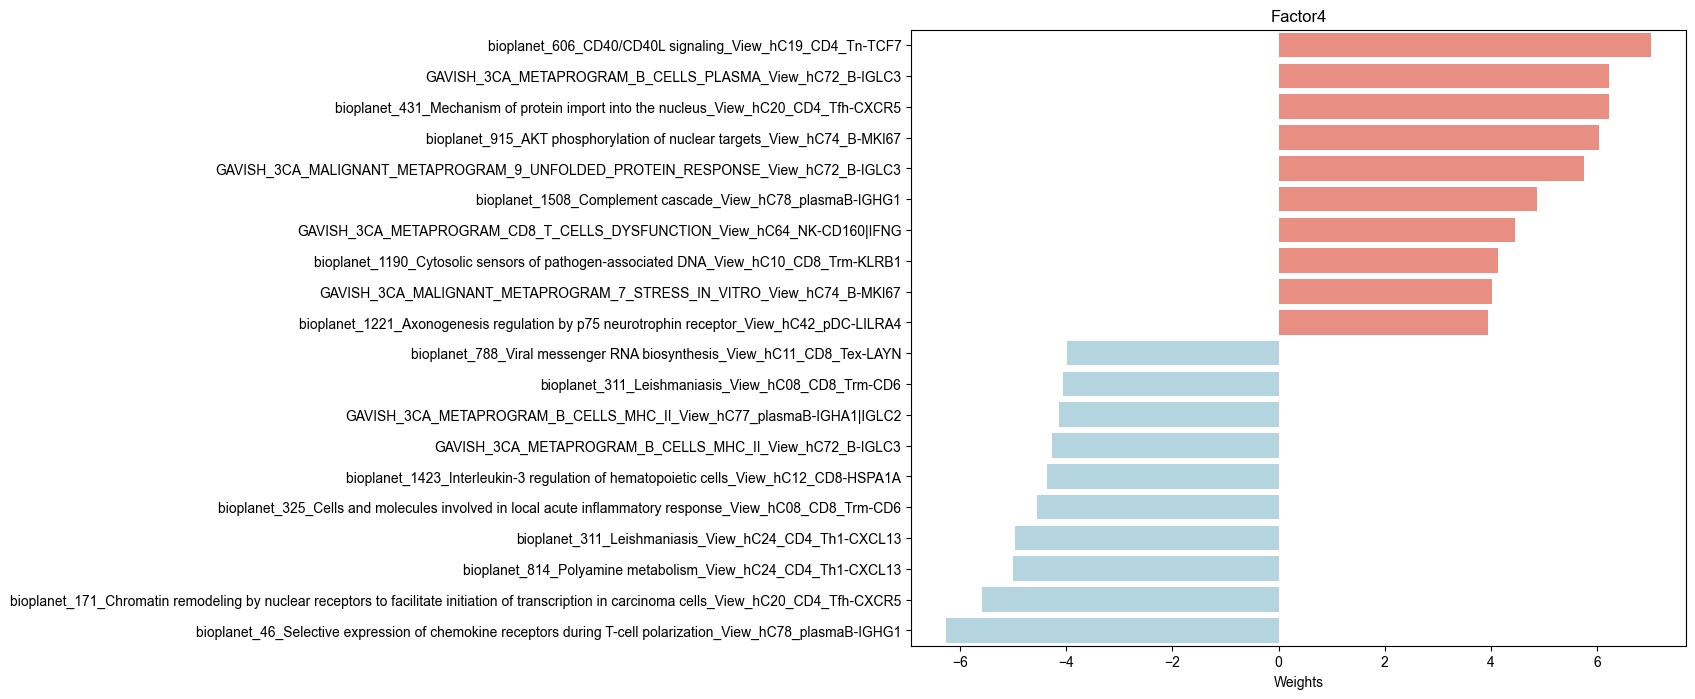

In [99]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor4',label_beside_bar=False,n_largest=10,n_smallest=10)
a1.savefig(f'../plot/20240722_GSE164522_TOP10WEIGHT_factor4.pdf',bbox_inches = "tight")

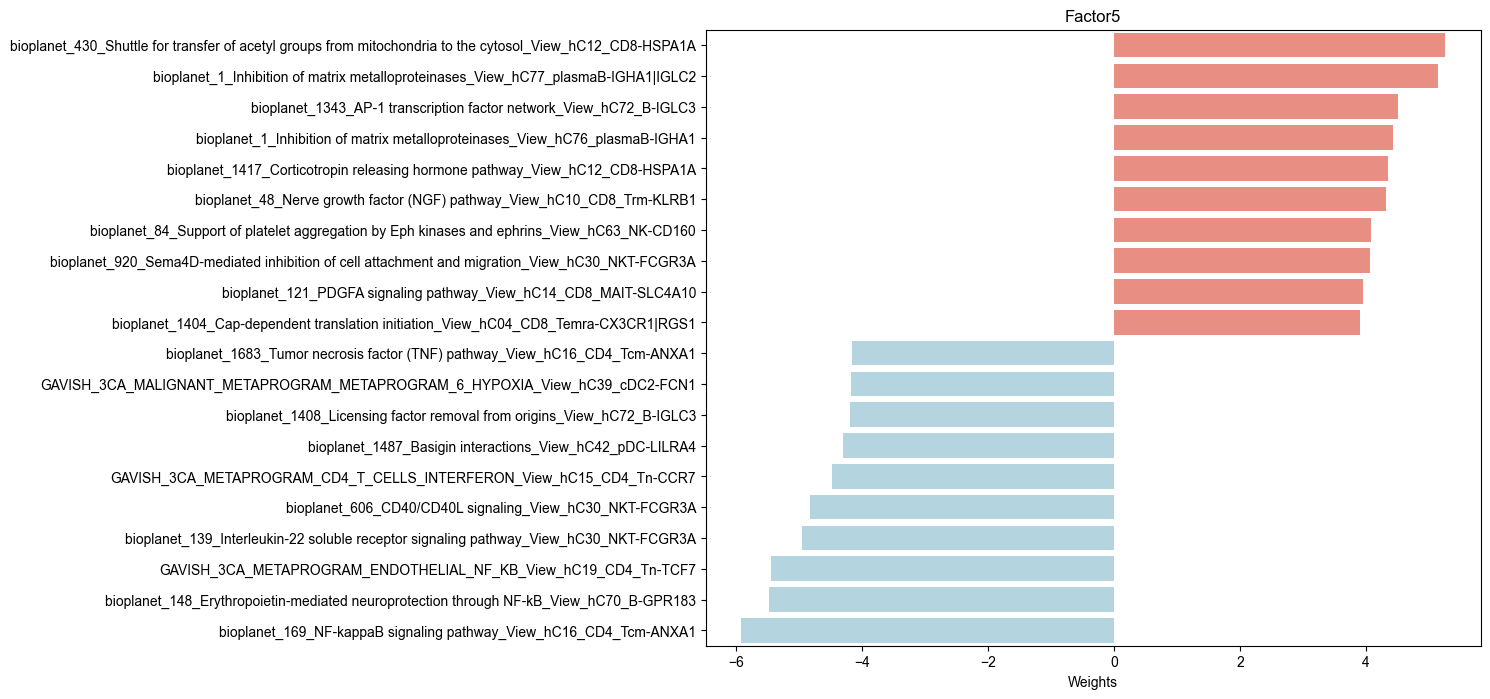

In [100]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor5',label_beside_bar=False,n_largest=10,n_smallest=10)
a1.savefig(f'../plot/20240722_GSE164522_TOP10WEIGHT_factor5.pdf',bbox_inches = "tight")

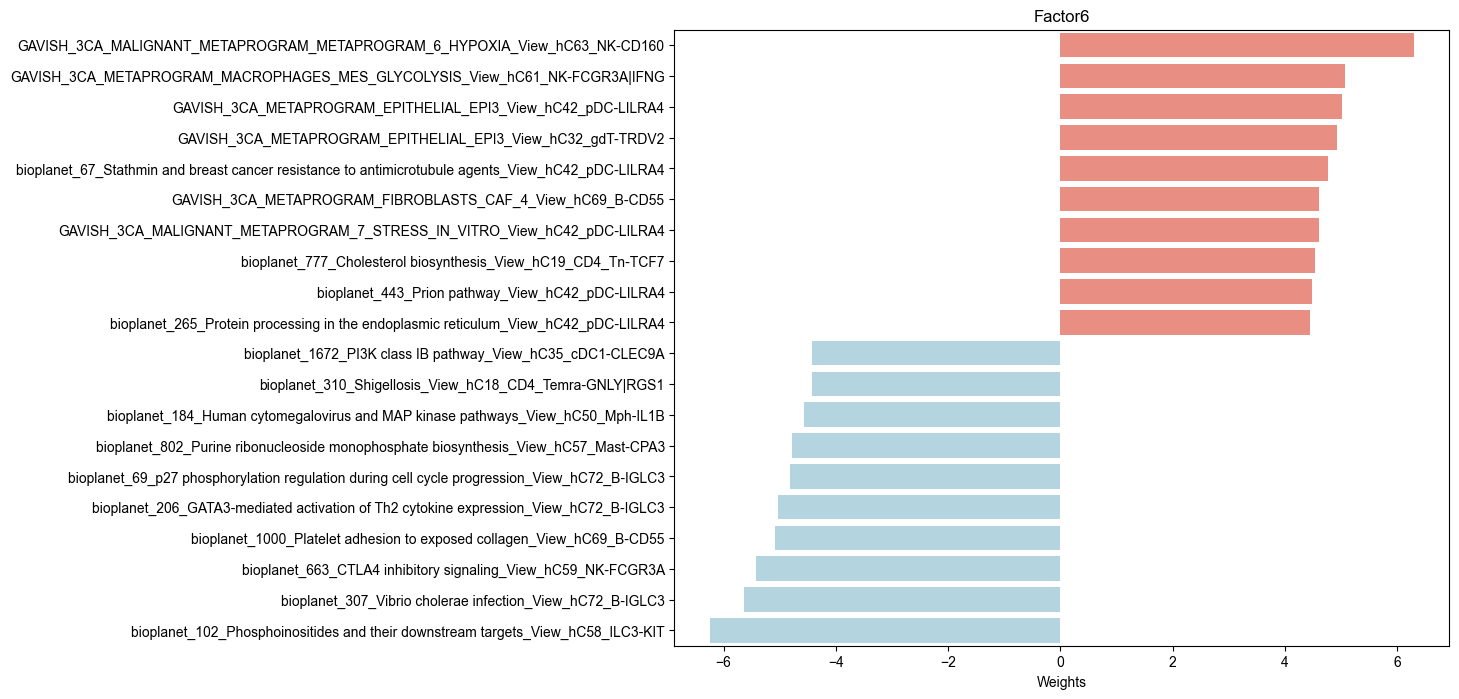

In [101]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor6',label_beside_bar=False,n_largest=10,n_smallest=10)
a1.savefig(f'../plot/20240722_GSE164522_TOP10WEIGHT_factor6.pdf',bbox_inches = "tight")